In [65]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd


In [66]:
# Parâmetros
C = 5  # capacidade total
R = 2  # reserva para tráfego prioritário (classe 1)
λ1 = 10 / 60  # taxa de chegada classe 1 (por minuto)
λ2 = 15 / 60  # taxa de chegada classe 2 (por minuto)
μ1 = 15 / 60  # taxa de serviço classe 1 (por minuto)
μ2 = 25 / 60  # taxa de serviço classe 2 (por minuto)

# Tempo total de simulação
T_max = 10_000  # minutos

In [67]:
def resolver_ctmc(C, R, λ1, λ2, μ1, μ2):
    """
    Resolve a distribuição estacionária π de uma CTMC com controle de admissão baseado em prioridade.

    Parâmetros:
        C  - Capacidade total do sistema
        R  - Reserva mínima para classe prioritária (classe 1)
        λ1 - Taxa de chegada da classe 1 (req/min)
        λ2 - Taxa de chegada da classe 2 (req/min)
        μ1 - Taxa de saída da classe 1 (1/tempo médio)
        μ2 - Taxa de saída da classe 2 (1/tempo médio)

    Retorna:
        π      - Distribuição estacionária (vetor)
        states - Lista de tuplas representando os estados válidos (i, j)
        Q      - Matriz infinitesimal de transição
    """
    # Estados válidos: (i, j) onde i = conexões classe 1, j = conexões classe 2
    states = [(i, j) for i in range(C + 1) for j in range(C + 1 - i) if i + j <= C]
    state_index = {s: idx for idx, s in enumerate(states)}
    n = len(states)
    Q = np.zeros((n, n))

    for idx, (i, j) in enumerate(states):
        # Chegadas
        if i + j < C:
            ni = (i + 1, j)
            if ni in state_index:
                Q[idx, state_index[ni]] = λ1
            if C - (i + j) > R:
                nj = (i, j + 1)
                if nj in state_index:
                    Q[idx, state_index[nj]] = λ2
        # Saídas
        if i > 0:
            ni = (i - 1, j)
            Q[idx, state_index[ni]] = i * μ1
        if j > 0:
            nj = (i, j - 1)
            Q[idx, state_index[nj]] = j * μ2

        # Diagonal
        Q[idx, idx] = -np.sum(Q[idx, :])

    # Resolver sistema linear π Q = 0 com soma π_i = 1
    A = np.copy(Q.T)
    A[-1, :] = 1
    b = np.zeros(n)
    b[-1] = 1

    π = np.linalg.solve(A, b)

    return π, states, Q

π, states, Q = resolver_ctmc(C, R, λ1, λ2, μ1, μ2)

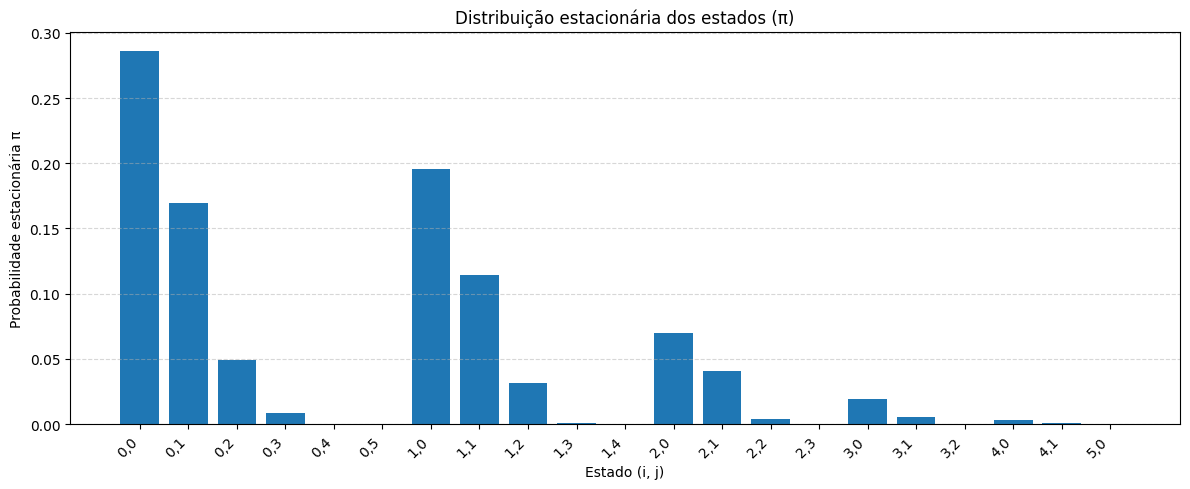

In [68]:
def plotar_distribuicao_pi(π, states):
    """
    Plota a distribuição estacionária π.

    Parâmetros:
        π      - Vetor com as probabilidades estacionárias
        states - Lista de estados correspondentes aos índices de π
    """
    state_labels = [f"{i},{j}" for (i, j) in states]

    plt.figure(figsize=(12, 5))
    plt.bar(range(len(π)), π, tick_label=state_labels)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Estado (i, j)")
    plt.ylabel("Probabilidade estacionária π")
    plt.title("Distribuição estacionária dos estados (π)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plotar_distribuicao_pi(π, states)


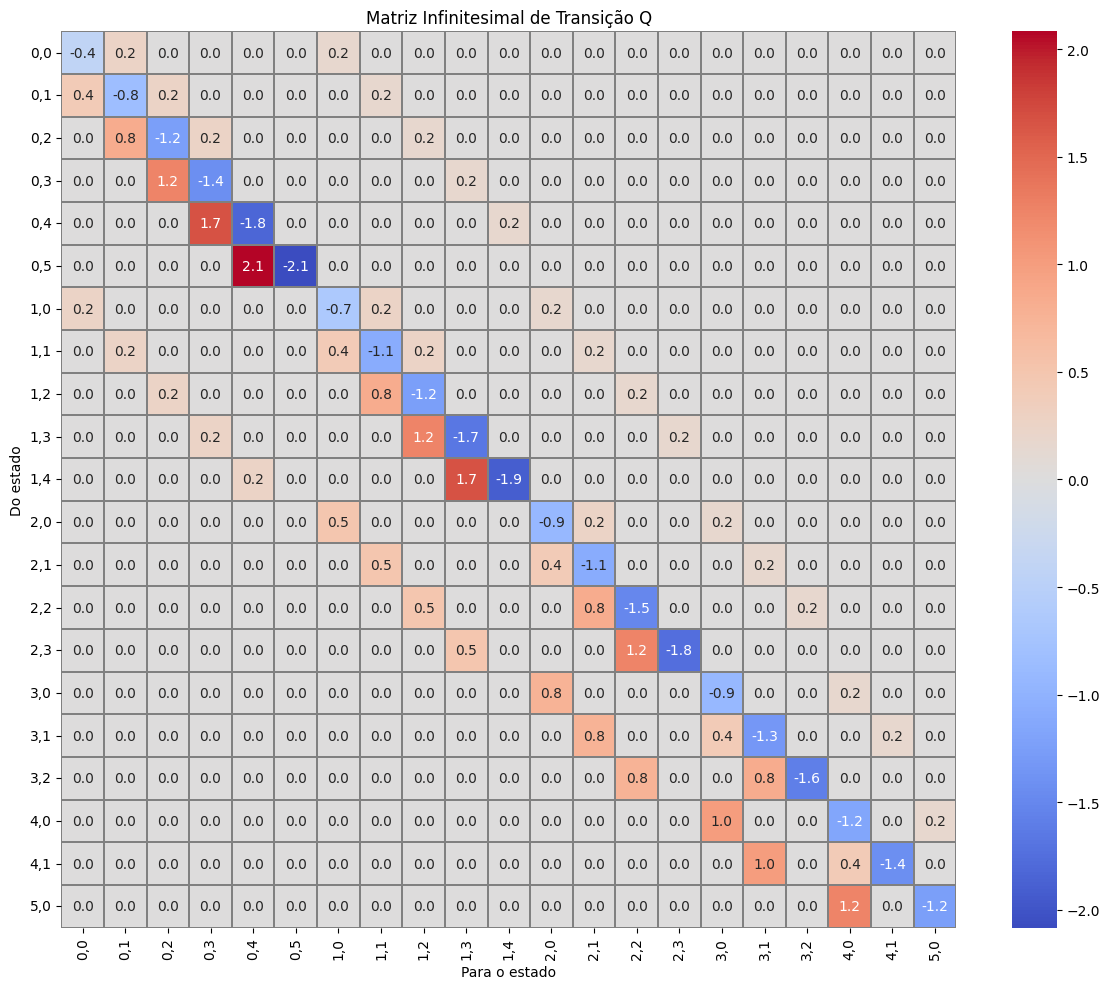

In [69]:
def plotar_matriz_Q(Q, states):
    """
    Plota a matriz infinitesimal de transição Q como um mapa de calor com anotações numéricas.

    Parâmetros:
        Q      - Matriz de transição infinitesimal (numpy.ndarray)
        states - Lista de estados (i, j), usada para rótulos
    """
    plt.figure(figsize=(12, 10))
    labels = [f"{i},{j}" for (i, j) in states]

    sns.heatmap(Q, annot=True, fmt=".1f", cmap="coolwarm",
                xticklabels=labels, yticklabels=labels, cbar=True, linewidths=0.3, linecolor='gray')
    plt.title("Matriz Infinitesimal de Transição Q")
    plt.xlabel("Para o estado")
    plt.ylabel("Do estado")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plotar_matriz_Q(Q, states)


In [70]:
def calcular_indicadores(π, states, C, R):
    """
    Calcula indicadores de desempenho do sistema baseado na distribuição estacionária.

    Parâmetros:
        π      - Distribuição estacionária
        states - Lista de estados válidos (i, j)
        C      - Capacidade total do sistema
        R      - Reserva mínima para tráfego prioritário (classe 1)

    Retorna:
        dict com os seguintes indicadores:
            - Prob_bloqueio_classe_1
            - Prob_bloqueio_classe_2
            - Utilizacao_media
            - Media_conexoes_classe_1
            - Media_conexoes_classe_2
            - Fracao_tempo_capacidade_maxima
    """
    state_index = {s: idx for idx, s in enumerate(states)}

    P_bloqueio_1 = sum(π[state_index[s]] for s in states if sum(s) == C)
    P_bloqueio_2 = sum(π[state_index[s]] for s in states if sum(s) >= C - R + 1)
    
    utilizacao = sum((i + j) * π[state_index[(i, j)]] for (i, j) in states)
    media_1 = sum(i * π[state_index[(i, j)]] for (i, j) in states)
    media_2 = sum(j * π[state_index[(i, j)]] for (i, j) in states)
    
    frac_max = sum(π[state_index[(i, j)]] for (i, j) in states if i + j == C)
    
    return {
        "Prob_bloqueio_classe_1": P_bloqueio_1,
        "Prob_bloqueio_classe_2": P_bloqueio_2,
        "Utilizacao_media": utilizacao,
        "Media_conexoes_classe_1": media_1,
        "Media_conexoes_classe_2": media_2,
        "Fracao_tempo_capacidade_maxima": frac_max
    }

# Exemplo de uso:
indicadores_analiticos = calcular_indicadores(π, states, C=5, R=2)


In [71]:

def imprimir_indicadores(indicadores):
    """
    Imprime os indicadores calculados.

    Parâmetros:
        indicadores - Dicionário com os indicadores a serem impressos
    """
    print("Indicadores de desempenho:")
    for key, value in indicadores.items():
        print(f"{key}: {value:.4f}")
imprimir_indicadores(indicadores_analiticos)

Indicadores de desempenho:
Prob_bloqueio_classe_1: 0.0016
Prob_bloqueio_classe_2: 0.0157
Utilizacao_media: 1.1959
Media_conexoes_classe_1: 0.6656
Media_conexoes_classe_2: 0.5304
Fracao_tempo_capacidade_maxima: 0.0016


In [72]:
def simular_ctmc(states, C, R, λ1, λ2, μ1, μ2, T_max, seed=None):
    """
    Simula uma CTMC com relógios exponenciais concorrentes e estima a distribuição estacionária π.

    Parâmetros:
        states - Lista de estados válidos (i, j)
        C      - Capacidade total do sistema
        R      - Reserva mínima para tráfego prioritário (classe 1)
        λ1, λ2 - Taxas de chegada para classes 1 e 2 (req/min)
        μ1, μ2 - Taxas de serviço para classes 1 e 2 (req/min)
        T_max  - Tempo máximo de simulação
        seed   - Semente aleatória (opcional, para reprodutibilidade)

    Retorna:
        pi_simulada - Distribuição estimada por simulação
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    current_state = (0, 0)
    time = 0.0
    state_counts = {s: 0.0 for s in states}

    while time < T_max:
        i, j = current_state
        rates = []

        # Chegadas
        if i + j < C:
            rates.append(("λ1", λ1, (i + 1, j)))
            if C - (i + j) > R:
                rates.append(("λ2", λ2, (i, j + 1)))

        # Saídas
        if i > 0:
            rates.append(("μ1", i * μ1, (i - 1, j)))
        if j > 0:
            rates.append(("μ2", j * μ2, (i, j - 1)))

        total_rate = sum(rate for _, rate, _ in rates)
        if total_rate == 0:
            break

        dt = np.random.exponential(1 / total_rate)
        if time + dt > T_max:
            dt = T_max - time

        state_counts[current_state] += dt
        time += dt

        r = random.uniform(0, total_rate)
        cumulative = 0.0
        for _, rate, next_state in rates:
            cumulative += rate
            if r <= cumulative:
                current_state = next_state
                break

    total_time = sum(state_counts.values())
    pi_simulada = np.array([state_counts[s] / total_time for s in states])

    return pi_simulada

pi_simulada = simular_ctmc(states, C=5, R=2, λ1=10, λ2=15, μ1=15, μ2=25, T_max=10000, seed=42)

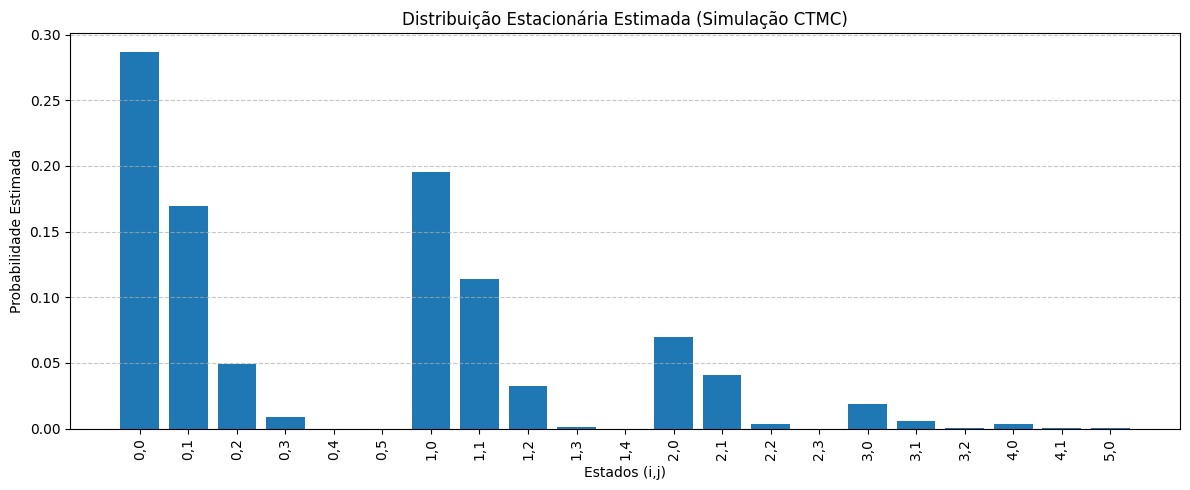

In [73]:
def plotar_distribuicao_simulada(pi_simulada, states):
    """
    Plota a distribuição estacionária estimada pela simulação da CTMC.

    Parâmetros:
        pi_simulada - Distribuição estacionária estimada (array)
        states      - Lista de estados correspondentes (i, j)
    """
    labels = [f"{i},{j}" for (i, j) in states]

    plt.figure(figsize=(12, 5))
    plt.bar(range(len(pi_simulada)), pi_simulada, tick_label=labels)
    plt.xticks(rotation=90)
    plt.xlabel("Estados (i,j)")
    plt.ylabel("Probabilidade Estimada")
    plt.title("Distribuição Estacionária Estimada (Simulação CTMC)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plotar_distribuicao_simulada(pi_simulada, states)


In [ ]:
def calcular_indicadores_simulados(pi_simulada, states, state_index, C, R):
    """
    Calcula os indicadores de desempenho com base na distribuição de estados simulada.

    Parâmetros:
        pi_simulada   - Distribuição simulada dos estados (lista ou array)
        states        - Lista de tuplas (i, j) representando os estados
        state_index   - Dicionário de mapeamento de estado para índice
        C             - Capacidade total do sistema
        R             - Unidades reservadas para classe 1

    Retorna:
        Um dicionário com os indicadores calculados
    """
    P_bloqueio_1_sim = sum(pi_simulada[state_index[s]] for s import numpy as np
in states if sum(s) == C)
    P_bloqueio_2_sim = sum(pi_simulada[state_index[s]] for s in states if sum(s) >= C - R + 1)

    utilizacao_sim = sum((i + j) * pi_simulada[state_index[(i, j)]] for (i, j) in states)
    media_1_sim = sum(i * pi_simulada[state_index[(i, j)]] for (i, j) in states)
    media_2_sim = sum(j * pi_simulada[state_index[(i, j)]] for (i, j) in states)
    frac_max_sim = sum(pi_simulada[state_index[(i, j)]] for (i, j) in states if i + j == C)

    return {
        "Prob_bloqueio_classe_1": P_bloqueio_1_sim,
        "Prob_bloqueio_classe_2": P_bloqueio_2_sim,
        "Utilizacao_media": utilizacao_sim,
        "Media_conexoes_classe_1": media_1_sim,
        "Media_conexoes_classe_2": media_2_sim,
        "Fracao_tempo_capacidade_maxima": frac_max_sim
    }

resultados_simulados = calcular_indicadores_simulados(pi_simulada, states, state_index, C, R)

In [ ]:
# Imprimindo os resultados simulados
imprimir_indicadores(resultados_simulados)
def comparar_resultados(analiticos, simulados):
    """
    Compara os resultados analíticos e simulados.
import numpy as np

    Parâmetros:
        analiticos - Dicionário com os resultados analíticos
        simulados  - Dicionário com os resultados simulados
    """
    print("\nComparação entre resultados analíticos e simulados:")
    for key in analiticos.keys():
        print(f"{key}: Analítico = {analiticos[key]:.4f}, Simulado = {simulados[key]:.4f}")

Indicadores de desempenho:
Prob_bloqueio_classe_1: 0.0017
Prob_bloqueio_classe_2: 0.0155
Utilizacao_media: 1.1947
Media_conexoes_classe_1: 0.6644
Media_conexoes_classe_2: 0.5304
Fracao_tempo_capacidade_maxima: 0.0017


In [ ]:
def comparar_resultados(resultados_analiticos, resultados_simulados):
    """
    Gera um DataFrame comparando os indicadores entre valores analíticos e simulados.

    Parâmetros:
        resultados_analiticos (dict): indicadores analíticos
        resultados_simulados (dict): indicadores simulados

    Retorna:
        pandas.DataFrame: tabela estruturada para exibição no notebook
    """
    indicadores = list(resultados_analiticos.keys())
    dados = {
        "Indicador": indicadores,
        "Valor Analítico": [resultados_analiticos[ind] for ind in indicadores],
        "Valor Simulado": [resultados_simulados[ind] for ind in indicadores]
    }
    
    df = pd.DataFrame(dados)
    
    # Formatação numérica customizada para melhor visualização
    def format_val(x, ind):
        if "Prob" in ind or "Fracao" in ind:
            return f"{x:.5f}"
        else:
            return f"{x:.3f}"
    
    df["Valor Analítico"] = [format_val(v, ind) for v, ind in zip(df["Valor Analítico"], indicadores)]
    df["Valor Simulado"] = [format_val(v, ind) for v, ind in zip(df["Valor Simulado"], indicadores)]
    
    return df

# Suponha que você já tenha os dois dicionários:
# resultados_analiticos e resultados_simulados

df_comparacao = comparar_resultados(indicadores_analiticos, resultados_simulados)
df_comparacao  # Ao executar essa linha no Jupyter, a tabela aparece formatada


,Indicador,Valor Analítico,Valor Simulado
0,Prob_bloqueio_classe_1,0.00164,0.00167
1,Prob_bloqueio_classe_2,0.01567,0.01551
2,Utilizacao_media,1.196,1.195
3,Media_conexoes_classe_1,0.666,0.664
4,Media_conexoes_classe_2,0.530,0.530
5,Fracao_tempo_capacidade_maxima,0.00164,0.00167


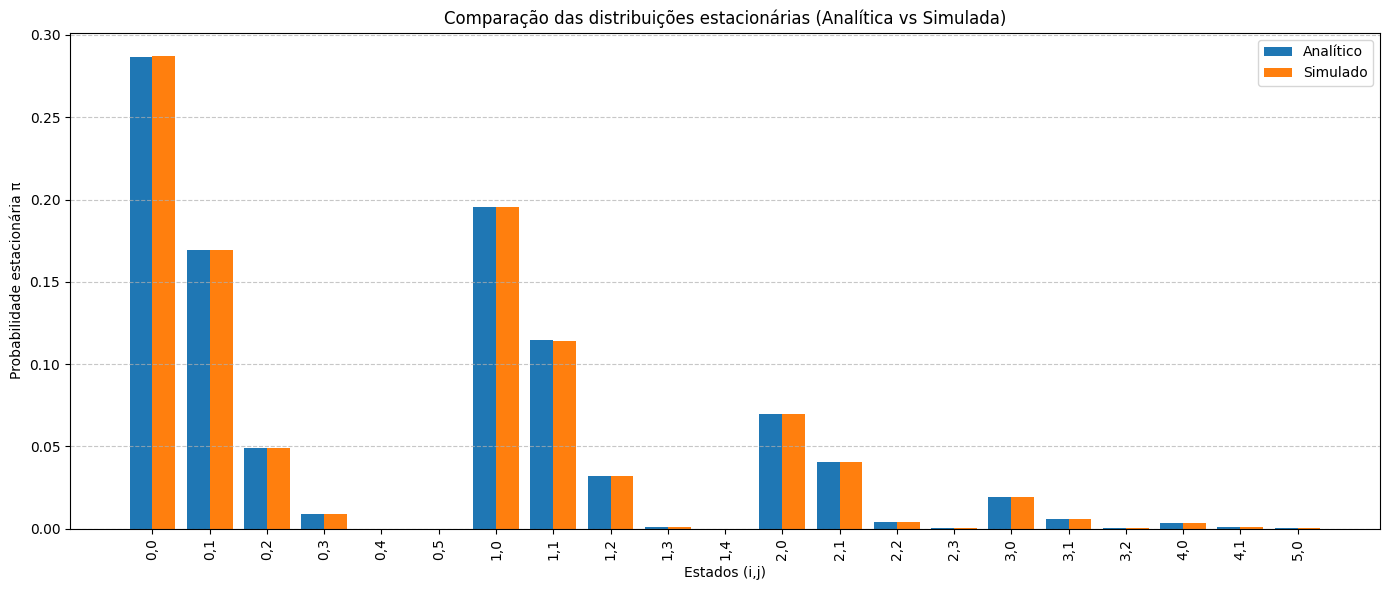

In [79]:
def plot_distribuicoes_comparacao(states, pi_analitica, pi_simulada):
    """
    Plota a distribuição estacionária analítica e simulada lado a lado para comparação.

    Parâmetros:
        states (list of tuple): lista de estados (i, j)
        pi_analitica (np.array): distribuição estacionária analítica
        pi_simulada (np.array): distribuição estacionária simulada
    """
    # Criar labels para os estados: "i,j"
    labels = [f"{i},{j}" for (i, j) in states]

    x = np.arange(len(states))
    width = 0.4

    fig, ax = plt.subplots(figsize=(14,6))
    rects1 = ax.bar(x - width/2, pi_analitica, width, label='Analítico')
    rects2 = ax.bar(x + width/2, pi_simulada, width, label='Simulado')

    ax.set_xlabel('Estados (i,j)')
    ax.set_ylabel('Probabilidade estacionária π')
    ax.set_title('Comparação das distribuições estacionárias (Analítica vs Simulada)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    
plot_distribuicoes_comparacao(states, π, pi_simulada)
